[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

In [1]:
%%capture --no-stderr
%pip install -U langchain_groq langgraph

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [4]:
from langchain_groq import ChatGroq

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model = ChatGroq(model="openai/gpt-oss-120b", 
                 api_key = os.environ["GROQ_API_KEY"],
                 temperature=0)

## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [5]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

Generate subjects for jokes.

In [6]:
import json

def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"]) + "\n\nPlease return the list of subjects as a JSON object with a single key 'subjects' containing a list of strings."
    response = model.invoke(prompt)
    try:
        subjects_data = json.loads(response.content)
        return {"subjects": subjects_data.get("subjects", [])}
    except json.JSONDecodeError:
        print("Could not parse JSON response for subjects.")
        return {"subjects": []}

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [7]:
from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`! 

This key has a reducer that will combine lists.

In [8]:
import json

class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"]) + "\n\nPlease return the joke as a JSON object with a single key 'joke' containing the joke string."
    response = model.invoke(prompt)
    try:
        joke_data = json.loads(response.content)
        return {"jokes": [joke_data.get("joke", "")]}
    except json.JSONDecodeError:
        print(f"Could not parse JSON response for joke about {state['subject']}.")
        return {"jokes": [""]}

### Best joke selection (reduce)

Now, we add logic to pick the best joke.

In [9]:
import json

def best_joke(state: OverallState):
    jokes = "\n\n".join([f"{i}: {joke}" for i, joke in enumerate(state["jokes"])])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes) + "\n\nPlease return the ID of the best joke as a JSON object with a single key 'id' containing an integer."
    response = model.invoke(prompt)
    try:
        best_joke_data = json.loads(response.content)
        selected_id = best_joke_data.get("id")
        if selected_id is not None and 0 <= selected_id < len(state["jokes"]):
            return {"best_selected_joke": state["jokes"][selected_id]}
        else:
            print("Could not determine the best joke ID from the JSON response.")
            return {"best_selected_joke": "Could not select a joke."}
    except json.JSONDecodeError:
        print("Could not parse JSON response for best joke selection.")
        return {"best_selected_joke": "Could not select a joke."}

## Compile

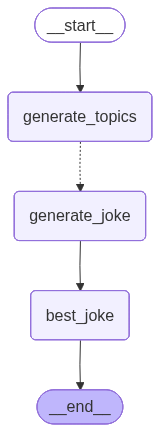

In [10]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [11]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['Mammalian behavior and social structures', 'Endangered species conservation', 'Adaptations of marine life']}}
{'generate_joke': {'jokes': ["Why did the meerkat start a support group? Because it heard that in mammalian societies, sharing the watch duty is the best way to avoid feeling left out—talk about a real 'guard'‑ian angel!"]}}
{'generate_joke': {'jokes': ['Why did the endangered panda start a podcast? Because it wanted to raise awareness—one *bear* minimum at a time!']}}
{'generate_joke': {'jokes': ["Why did the fish bring a ladder to the coral reef? Because it heard the reef was developing a new 'upward' adaptation and wanted to stay a step ahead!"]}}
{'best_joke': {'best_selected_joke': 'Why did the endangered panda start a podcast? Because it wanted to raise awareness—one *bear* minimum at a time!'}}


Here is the input and output observed in continue_to_jokes under the generate_topics state in LangSmith traces:

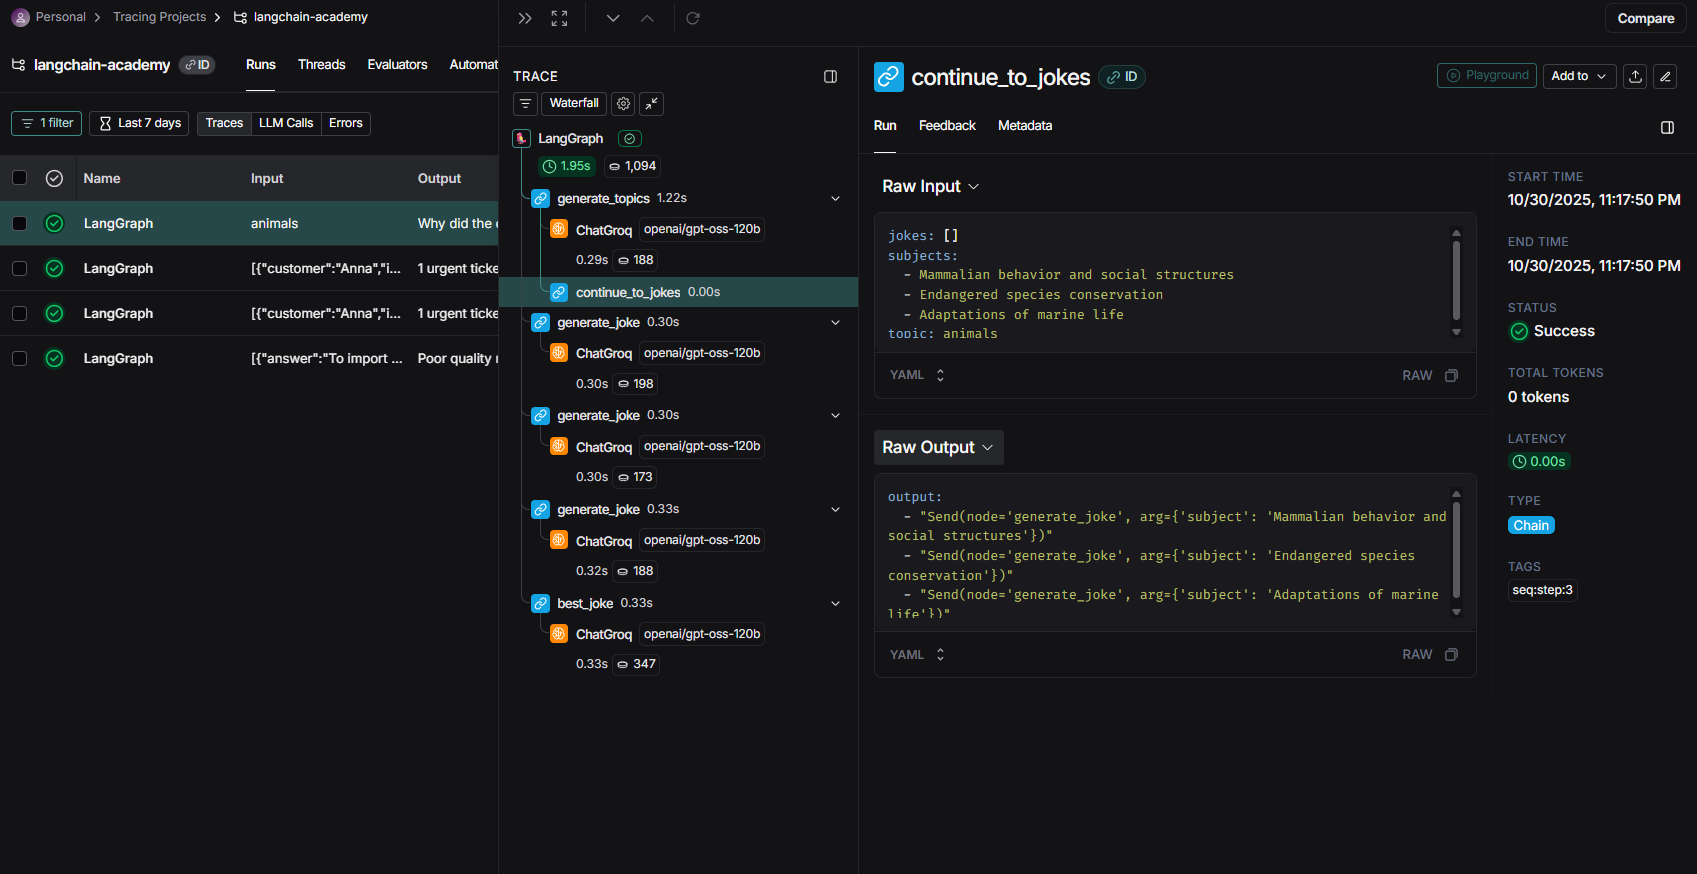

Output of one of the joke topic asked:



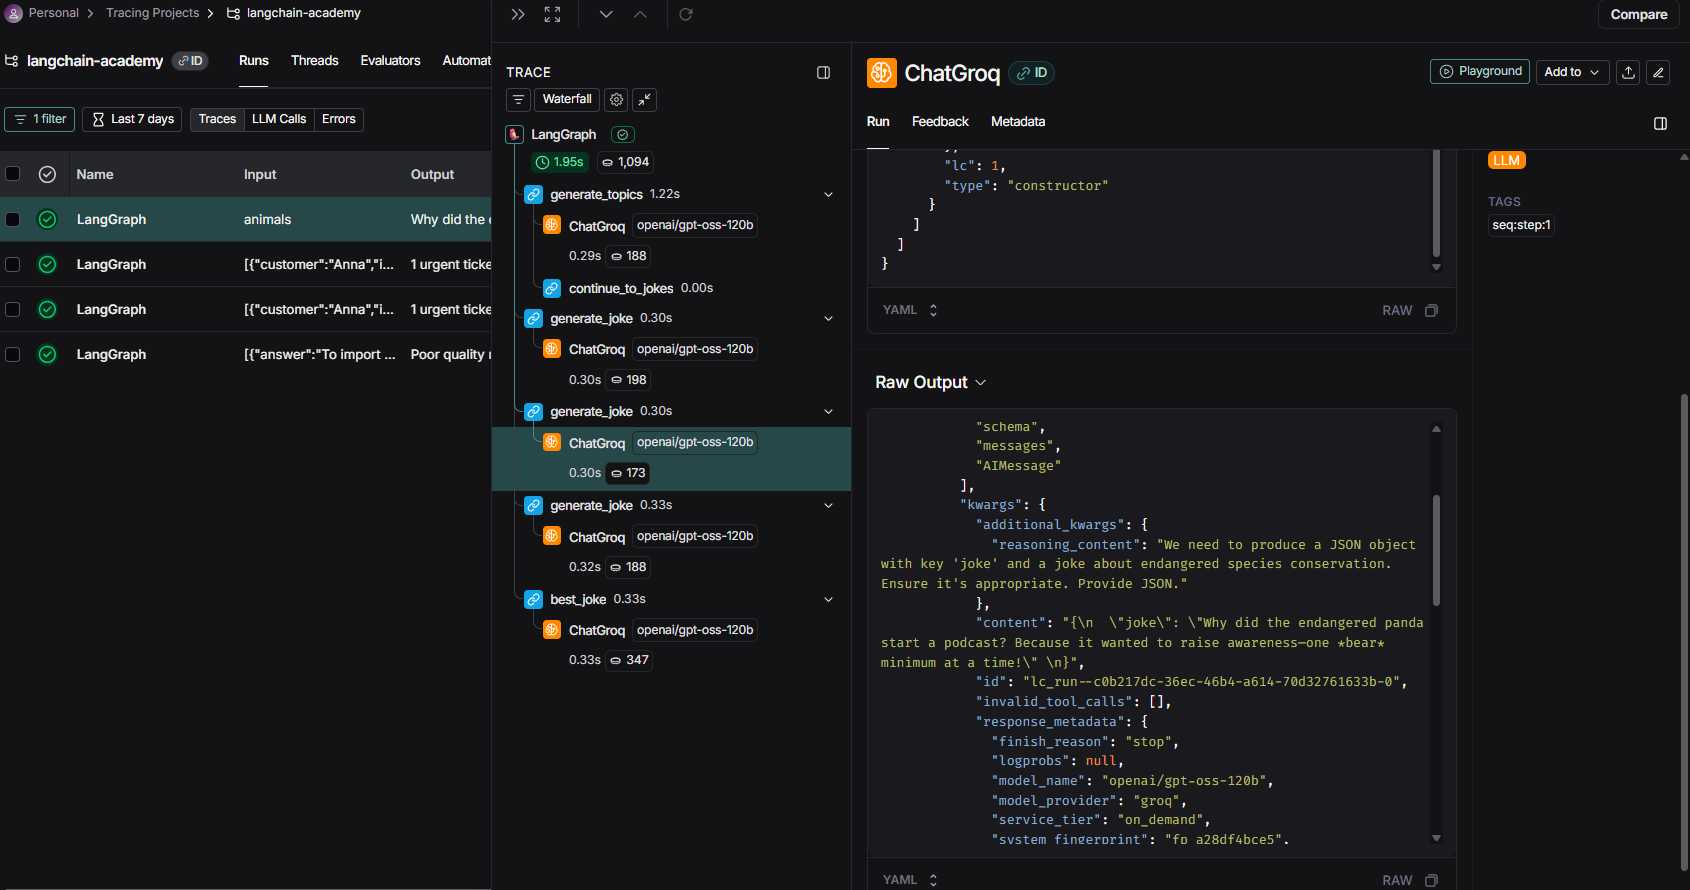

The best joke chosen by the model:

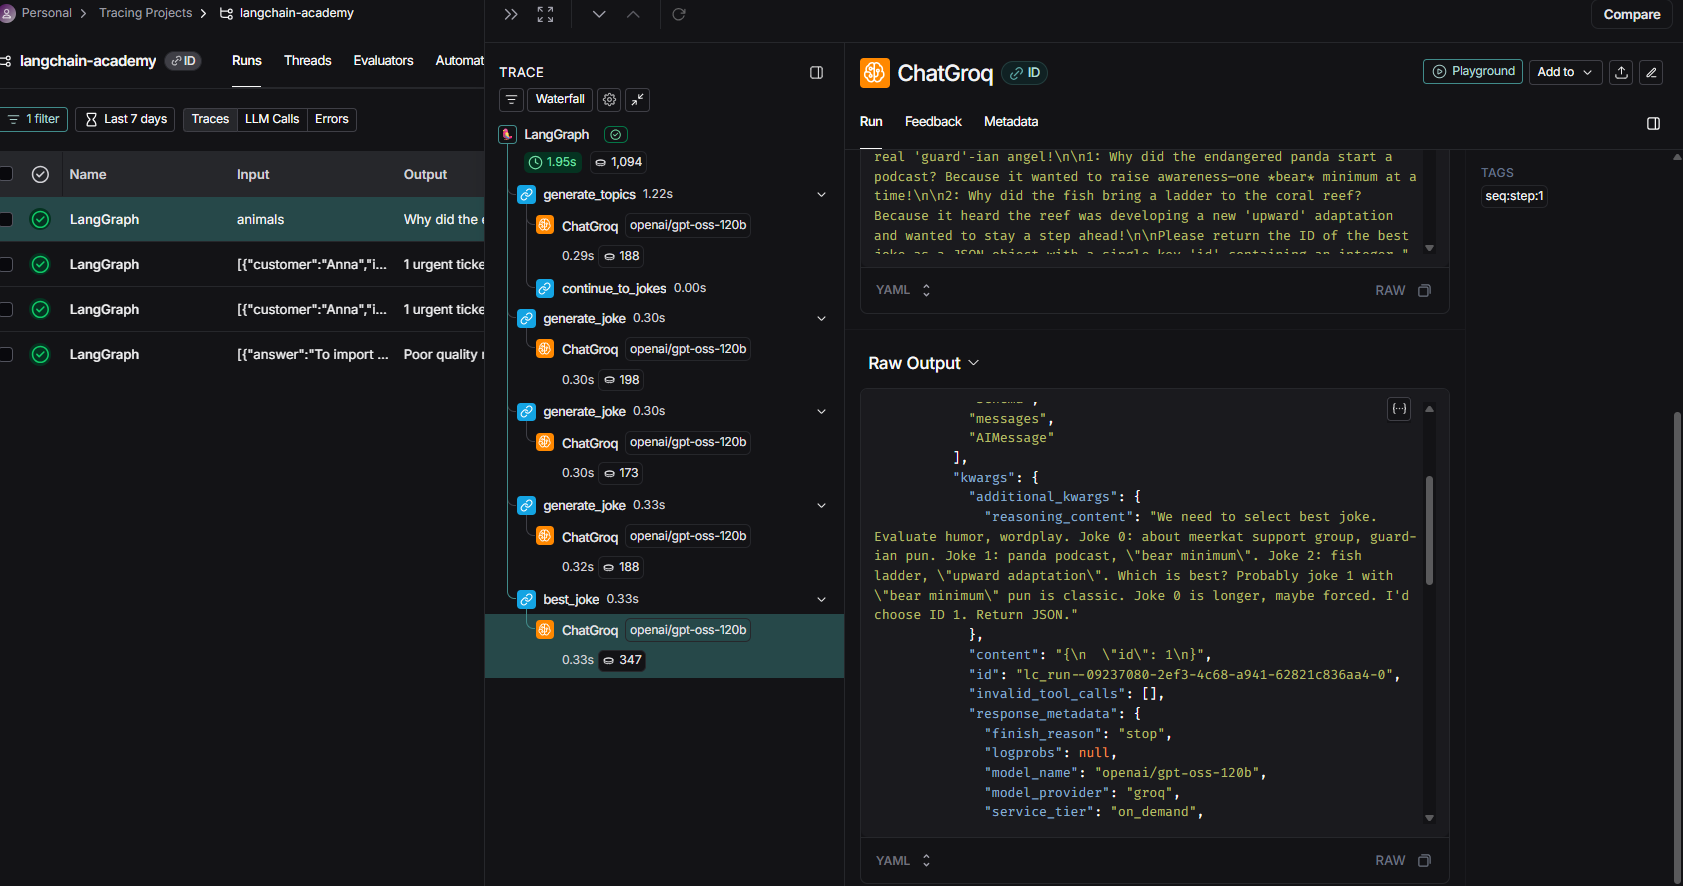

## Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

Let's load our the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.

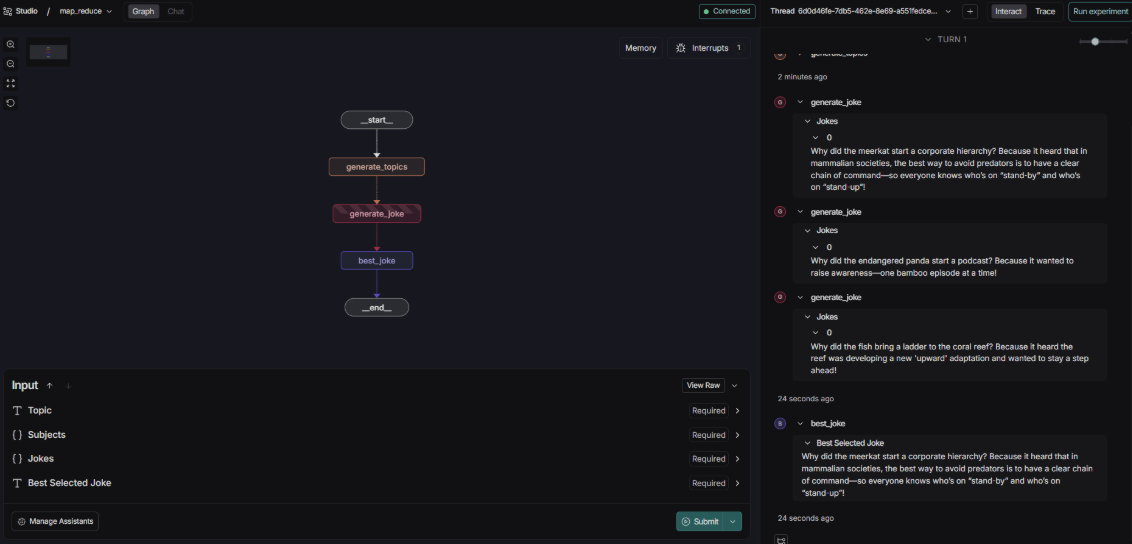

# MY EXAMPLES:

Job Candidate Screening & Selection from Multiple Hiring Teams

In [12]:
import os, json, operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain_groq import ChatGroq

model = ChatGroq(
    model="openai/gpt-oss-120b",
    api_key=os.environ.get("GROQ_API_KEY"),
    temperature=0
)


Define data models and overall state:

In [13]:
class Teams(BaseModel):
    teams: list[str]

class Candidate(BaseModel):
    name: str

class EvalResult(BaseModel):
    name: str
    team: str
    suitability: float
    fit: float
    score: float

class BestCandidate(BaseModel):
    name: str

class OverallState(TypedDict):
    role: str
    teams: list
    candidates: Annotated[list, operator.add]
    evaluations: Annotated[list, operator.add]
    best_per_team: dict
    best_overall: str


Define prompt templates:

In [14]:
teams_prompt = """
Given the job role: {role}, generate a JSON array "teams" with 3 hiring team personas.
Example: {{ "teams": ["Engineering leads", "HR specialists", "Design managers"] }}
"""

candidates_prompt = """
You are {team}, tasked to shortlist 3 promising candidates for the role: {role}.
Return JSON: {{ "candidates": ["...", "...", "..."] }}
"""

evaluation_prompt = """
Evaluate candidate "{name}" proposed by {team} for role "{role}".
Return JSON: {{ "suitability": 0.0-1.0, "fit": 0.0-1.0 }}
Keep values between 0 and 1.
"""


Define graph nodes:

In [16]:
def generate_teams(state: OverallState):
    prompt = teams_prompt.format(role=state["role"])
    response = model.invoke(prompt)
    try:
        data = json.loads(response.content)
        return {"teams": data.get("teams", [])}
    except json.JSONDecodeError:
        print("Failed to parse teams JSON, using defaults.")
        return {"teams": ["Engineering", "HR", "Design"]}
    
def continue_to_candidates(state: OverallState):
    return [Send("generate_candidates", {"role": state["role"], "team": t}) for t in state["teams"]]



Generate candidate profiles per team:

In [17]:
def generate_candidates(state):
    prompt = candidates_prompt.format(role=state["role"], team=state["team"])
    response = model.invoke(prompt)
    try:
        data = json.loads(response.content)
        candidates = data.get("candidates", [])
        annotated = [{"name": c, "team": state["team"]} for c in candidates]
        return {"candidates": annotated}
    except json.JSONDecodeError:
        print(f"Failed to parse candidates for team {state['team']}")
        return {"candidates": []}


Parallelize candidate evaluation:

In [18]:
def continue_to_evaluations(state: OverallState):
    sends = []
    for c in state["candidates"]:
        sends.append(Send("evaluate_candidate", {"role": state["role"], "name": c["name"], "team": c["team"]}))
    return sends


Evaluate each candidate:

In [19]:
def evaluate_candidate(state):
    prompt = evaluation_prompt.format(role=state["role"], name=state["name"], team=state["team"])
    response = model.invoke(prompt)
    try:
        data = json.loads(response.content)
        suitability = float(data.get("suitability", 0))
        fit = float(data.get("fit", 0))
        score = 0.7 * suitability + 0.3 * fit
        eval_result = {
            "name": state["name"],
            "team": state["team"],
            "suitability": suitability,
            "fit": fit,
            "score": score
        }
        return {"evaluations": [eval_result]}
    except json.JSONDecodeError:
        print(f"Failed to parse evaluation for {state['name']}")
        return {"evaluations": []}


Select the best candidates:

In [20]:
def select_best(state: OverallState):
    evals = state.get("evaluations", [])
    if not evals:
        return {"best_per_team": {}, "best_overall": "No evaluations found"}

    # Best overall
    best_overall = max(evals, key=lambda e: e["score"])

    # Best per team
    from collections import defaultdict
    team_groups = defaultdict(list)
    for e in evals:
        team_groups[e["team"]].append(e)
    best_teamwise = {team: max(items, key=lambda x: x["score"]) for team, items in team_groups.items()}

    return {"best_per_team": best_teamwise, "best_overall": best_overall["name"]}


Build the graph:

In [21]:
graph = StateGraph(OverallState)

graph.add_node("generate_teams", generate_teams)
graph.add_node("generate_candidates", generate_candidates)
graph.add_node("evaluate_candidate", evaluate_candidate)
graph.add_node("select_best", select_best)

graph.add_edge(START, "generate_teams")
graph.add_conditional_edges("generate_teams", continue_to_candidates, ["generate_candidates"])
graph.add_conditional_edges("generate_candidates", continue_to_evaluations, ["evaluate_candidate"])
graph.add_edge("evaluate_candidate", "select_best")
graph.add_edge("select_best", END)

app = graph.compile()


Run the graph

In [22]:
input_state = {"role": "Machine Learning Engineer"}

final_state = None
for s in app.stream(input_state):
    print(s)
    final_state = s

print("\n--- Final summarized results ---")
try:
    res = app.run(input_state)
    print(json.dumps(res, indent=2))
except Exception:
    print("Streaming final state above; check 'best_per_team' and 'best_overall' in last output.")


Failed to parse teams JSON, using defaults.
{'generate_teams': {'teams': ['Engineering', 'HR', 'Design']}}
{'generate_candidates': {'candidates': [{'name': 'Alexandra Patel', 'team': 'Engineering'}, {'name': 'Jianyu Liu', 'team': 'Engineering'}, {'name': 'Mateo Rodríguez', 'team': 'Engineering'}]}}
{'generate_candidates': {'candidates': [{'name': 'Aisha Patel', 'team': 'HR'}, {'name': 'Liam Chen', 'team': 'HR'}, {'name': 'Sofia Martinez', 'team': 'HR'}]}}
{'generate_candidates': {'candidates': [{'name': 'Alexandra Patel', 'team': 'Design'}, {'name': 'Jianyu Liu', 'team': 'Design'}, {'name': 'Mateo Rodríguez', 'team': 'Design'}]}}
{'evaluate_candidate': {'evaluations': [{'name': 'Mateo Rodríguez', 'team': 'Engineering', 'suitability': 0.5, 'fit': 0.5, 'score': 0.5}]}}
{'evaluate_candidate': {'evaluations': [{'name': 'Alexandra Patel', 'team': 'Design', 'suitability': 0.5, 'fit': 0.5, 'score': 0.5}]}}
{'evaluate_candidate': {'evaluations': [{'name': 'Jianyu Liu', 'team': 'Engineering', '